### Reading-in the data

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [473]:
def read_clean_data(filename):
    df = pd.read_csv(filename)[['title','artist','year','bpm', 'nrgy', 'dnce', 'dB','live', 'val', 'dur','acous', 'spch','pop']]
    df = df.rename({'bpm':'tempo','nrgy':'energy','dnce':'danceability','dB':'loudness','live':'liveness',
                  'val':'valence','dur':'duration','acous':'acousticness','spch':'speechiness','pop':'popularity'},
                 axis = 1)
    df['decade'] = filename[2:4] + 's'
    return df

In [474]:
from sklearn.preprocessing import LabelEncoder

filenames = ['1980.csv','2010.csv']

df = pd.concat([read_clean_data(i) for i in filenames]).reset_index()
df = df.iloc[:,4:]
X = df.iloc[:,0:len(df.columns)-1]
y = df["decade"].values

y = le.transform(y)
le.classes_ 
# 10s - 0
# 80s - 1

array(['10s', '80s'], dtype=object)

In [475]:
# Descriptive statistics
df[df["decade"]=="80s"].describe().T.drop("count",axis=1)

df[df["decade"]=="10s"].describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
tempo,118.72,22.389157,75.0,101.50,120.0,134.0,186.0
energy,67.98,16.261114,17.0,56.75,68.0,80.0,95.0
danceability,65.37,11.880427,21.0,58.00,67.0,74.0,91.0
loudness,-5.49,2.002498,-13.0,-6.00,-5.0,-4.0,-2.0
liveness,17.93,13.822288,3.0,9.75,13.0,25.0,82.0
valence,46.35,20.945034,9.0,29.00,47.0,61.0,97.0
duration,209.17,24.080276,157.0,194.00,209.0,222.0,306.0
acousticness,14.71,17.911846,0.0,3.75,9.0,19.0,84.0
speechiness,8.44,7.820357,3.0,4.00,6.0,10.0,46.0
popularity,75.97,9.209629,32.0,71.75,78.0,82.0,94.0


In [476]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def do_pca(x,n_components=2,**kwargs): 
    pca = PCA(n_components,**kwargs)
    x_trans = pca.fit_transform(x)
    return x_trans, pca


# should have use pipeline here
# iprastai naudojant ross-validation kiekvienam foldui Scaler ir PCA turetu buti apmokoma atskirai
# ant tuo metu turimu train duomenu, bet siuo atvjeu manau minimalus skirtumas
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_small_test, pca = do_pca(X_test,n_components=2)
X_small_train = pca.transform(X_train)

Text(0.5, 1.0, 'Songs by decade (reduced dimensionality data)')

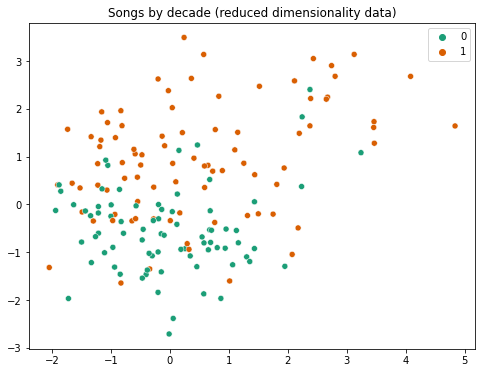

In [477]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
plot = sns.scatterplot(x=X_small_train[:,0],y=X_small_train[:,1],hue=y_train,palette="Dark2",ax=ax)
plot.set_title("Songs by decade (reduced dimensionality data)")

In [478]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [479]:
def fit_model(model,param_grid,X_train,y_train,output=True):
    cv=KFold(n_splits=5,shuffle=True,random_state=123)
    grid_search = GridSearchCV(model,param_grid=param_grid,cv=cv)
    grid_search.fit(X_train,y_train)
    if output:
        for i,j in grid_search.cv_results_.items():
            if "param_" in i or i == "mean_test_score":
                print(i,j)
        print("\n")
    return grid_search

In [480]:
def metric(model,X_test,y_test):
    y_pred = model.predict(X_test)
    cr = classification_report(y_test,y_pred,output_dict=True)
    cr = pd.DataFrame(cr).transpose()
    print(cr)
    print(confusion_matrix(y_test,y_pred))

In [481]:
from mlxtend.plotting import plot_decision_regions
def plot_decision(model,X,y,title=""):
    fig, ax = plt.subplots()
    plot_decision_regions(X,y,clf=model,legend=2,ax=ax)
    ax.set_title(title)

### KNN Classifier

In [482]:
def fit_knn(X_train,y_train,output=True,param_grid=None):
    knn = KNeighborsClassifier()
    if param_grid is None:
        param_grid = {"n_neighbors":[3,5,7],"weights": ['uniform', 'distance']}

    return fit_model(knn,param_grid,X_train,y_train,output)

knn_best = fit_knn(X_train,y_train).best_estimator_
metric(knn_best,X_test,y_test)

knn_best.get_params()

param_n_neighbors [3 3 5 5 7 7]
param_weights ['uniform' 'distance' 'uniform' 'distance' 'uniform' 'distance']
mean_test_score [0.8657197 0.8719697 0.8780303 0.8842803 0.8719697 0.8719697]


              precision    recall  f1-score    support
0              0.739130  0.772727  0.755556  22.000000
1              0.722222  0.684211  0.702703  19.000000
accuracy       0.731707  0.731707  0.731707   0.731707
macro avg      0.730676  0.728469  0.729129  41.000000
weighted avg   0.731295  0.731707  0.731063  41.000000
[[17  5]
 [ 6 13]]


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [483]:
knn_small_best = fit_knn(X_small_train,y_train).best_estimator_

metric(knn_small_best,X_small_test,y_test)

knn_small_best.get_params()

param_n_neighbors [3 3 5 5 7 7]
param_weights ['uniform' 'distance' 'uniform' 'distance' 'uniform' 'distance']
mean_test_score [0.75568182 0.73125    0.75568182 0.71912879 0.76193182 0.7375    ]


              precision    recall  f1-score    support
0              0.730769  0.863636  0.791667  22.000000
1              0.800000  0.631579  0.705882  19.000000
accuracy       0.756098  0.756098  0.756098   0.756098
macro avg      0.765385  0.747608  0.748775  41.000000
weighted avg   0.762852  0.756098  0.751913  41.000000
[[19  3]
 [ 7 12]]


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

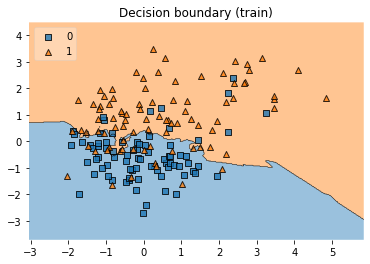

In [484]:
plot_decision(knn_small_best,X_small_train,y_train,title="Decision boundary (train)")

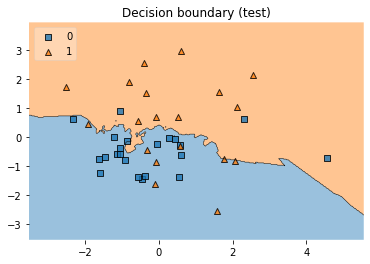

In [485]:
plot_decision(knn_small_best,X_small_test,y_test,title="Decision boundary (test)")

### Naive Bayes

In [486]:
def fit_nb(X_train,y_train,output=True,param_grid=None):
    nb = GaussianNB()
    if param_grid is None:
        param_grid = {}
    return fit_model(nb,param_grid,X_train,y_train,output)


nb_best = fit_nb(X_train,y_train).best_estimator_

metric(nb_best,X_test,y_test)

mean_test_score [0.89640152]


              precision    recall  f1-score    support
0              0.900000  0.818182  0.857143  22.000000
1              0.809524  0.894737  0.850000  19.000000
accuracy       0.853659  0.853659  0.853659   0.853659
macro avg      0.854762  0.856459  0.853571  41.000000
weighted avg   0.858072  0.853659  0.853833  41.000000
[[18  4]
 [ 2 17]]


In [487]:
nb_small_best = fit_nb(X_small_train,y_train).best_estimator_

metric(nb_small_best,X_small_test,y_test)

mean_test_score [0.77462121]


              precision    recall  f1-score    support
0              0.720000  0.818182  0.765957  22.000000
1              0.750000  0.631579  0.685714  19.000000
accuracy       0.731707  0.731707  0.731707   0.731707
macro avg      0.735000  0.724880  0.725836  41.000000
weighted avg   0.733902  0.731707  0.728772  41.000000
[[18  4]
 [ 7 12]]


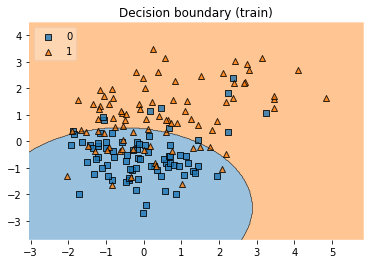

In [488]:
plot_decision(nb_small_best,X_small_train,y_train,title="Decision boundary (train)")

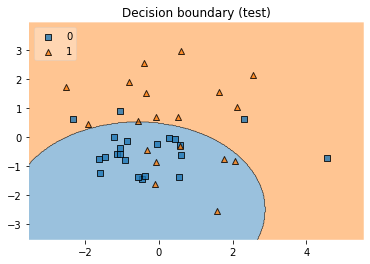

In [489]:
plot_decision(nb_small_best,X_small_test,y_test,title="Decision boundary (test)")

### Decision Tree

In [490]:
def fit_dt(X_train,y_train,output=True,param_grid=None):
    dt = DecisionTreeClassifier()
    if param_grid is None:
        param_grid = {"max_depth":[2,3,4],"min_samples_split":[5,10,15,20,25]}
    return fit_model(dt,param_grid,X_train,y_train,output)

dt_best = fit_dt(X_train,y_train).best_estimator_

metric(dt_best,X_test,y_test)

dt_best.get_params()

param_max_depth [2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
param_min_samples_split [5 10 15 20 25 5 10 15 20 25 5 10 15 20 25]
mean_test_score [0.74393939 0.74393939 0.74393939 0.74393939 0.74393939 0.78693182
 0.76268939 0.75056818 0.75681818 0.76287879 0.78087121 0.78693182
 0.75662879 0.74469697 0.75681818]


              precision    recall  f1-score    support
0              0.750000  0.818182  0.782609  22.000000
1              0.764706  0.684211  0.722222  19.000000
accuracy       0.756098  0.756098  0.756098   0.756098
macro avg      0.757353  0.751196  0.752415  41.000000
weighted avg   0.756815  0.756098  0.754625  41.000000
[[18  4]
 [ 6 13]]


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [491]:
dt_small_best  = fit_dt(X_small_train,y_train).best_estimator_

metric(dt_small_best,X_small_test,y_test)

dt_small_best.get_params()

param_max_depth [2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
param_min_samples_split [5 10 15 20 25 5 10 15 20 25 5 10 15 20 25]
mean_test_score [0.73712121 0.73712121 0.73712121 0.73712121 0.73712121 0.74943182
 0.76155303 0.76761364 0.76761364 0.76155303 0.73106061 0.74924242
 0.76136364 0.77348485 0.77348485]


              precision    recall  f1-score    support
0              0.761905  0.727273  0.744186  22.000000
1              0.700000  0.736842  0.717949  19.000000
accuracy       0.731707  0.731707  0.731707   0.731707
macro avg      0.730952  0.732057  0.731067  41.000000
weighted avg   0.733217  0.731707  0.732027  41.000000
[[16  6]
 [ 5 14]]


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

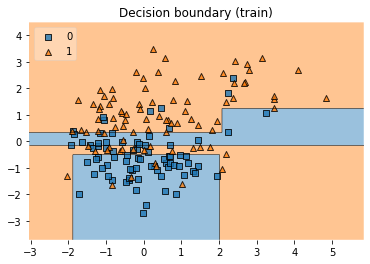

In [492]:
plot_decision(dt_small_best,X_small_train,y_train,title="Decision boundary (train)")

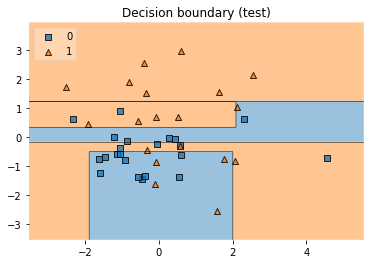

In [493]:
plot_decision(dt_small_best,X_small_test,y_test,title="Decision boundary (test)")

### Random forest

In [463]:
def fit_rf(X_train,y_train,output=True,param_grid=None):
    rf = RandomForestClassifier()
    if param_grid is None:
        param_grid = {"max_features":[2,3,4,5],"min_samples_split":[5,10,15,20,25],"n_estimators":[100]}
    return fit_model(rf,param_grid,X_train,y_train,output)

rf_best = fit_rf(X_train,y_train).best_estimator_

metric(rf_best,X_test,y_test)


rf_best.get_params()

param_max_features [2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5]
param_min_samples_split [5 10 15 20 25 5 10 15 20 25 5 10 15 20 25 5 10 15 20 25]
param_n_estimators [100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100]
mean_test_score [0.90833333 0.89034091 0.89621212 0.89602273 0.89621212 0.91458333
 0.89015152 0.88390152 0.89015152 0.88409091 0.91458333 0.90852273
 0.89621212 0.89640152 0.90852273 0.91477273 0.90246212 0.89640152
 0.88409091 0.88390152]


              precision    recall  f1-score    support
0              0.809524  0.772727  0.790698  22.000000
1              0.750000  0.789474  0.769231  19.000000
accuracy       0.780488  0.780488  0.780488   0.780488
macro avg      0.779762  0.781100  0.779964  41.000000
weighted avg   0.781940  0.780488  0.780750  41.000000
[[17  5]
 [ 4 15]]


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [470]:
rf_small_best = fit_rf(X_small_train,y_train, param_grid = {"max_features":[1],
                                                            "min_samples_split":[5,10,15,20,25],
                                                            "n_estimators":[100]}).best_estimator_

metric(rf_small_best,X_small_test,y_test)


rf_small_best.get_params()

param_max_features [1 1 1 1 1]
param_min_samples_split [5 10 15 20 25]
param_n_estimators [100 100 100 100 100]
mean_test_score [0.75549242 0.77367424 0.74924242 0.76174242 0.75530303]


              precision    recall  f1-score    support
0              0.800000  0.727273  0.761905  22.000000
1              0.714286  0.789474  0.750000  19.000000
accuracy       0.756098  0.756098  0.756098   0.756098
macro avg      0.757143  0.758373  0.755952  41.000000
weighted avg   0.760279  0.756098  0.756388  41.000000
[[16  6]
 [ 4 15]]


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

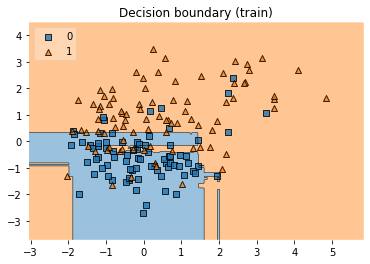

In [471]:
plot_decision(rf_small_best,X_small_train,y_train,title="Decision boundary (train)")

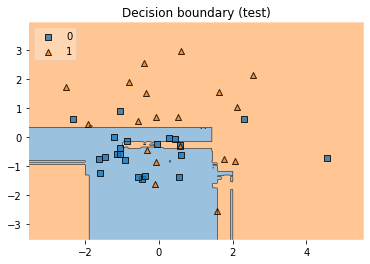

In [472]:
plot_decision(rf_small_best,X_small_test,y_test,title="Decision boundary (test)")

### Classification evaluation

In [431]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [564]:
def cross_validation_ROC_AUC(models,names,X_train,y_train):
    cv=KFold(n_splits=5,shuffle=True,random_state=123)
    for i,j in zip(models,names):
        y_proba = cross_val_predict(i,X_train,y_train,method="predict_proba",cv=cv)
        fpr, tpr, _ = roc_curve(y_train, y_proba[:,1])
        auc = round(roc_auc_score(y_train, y_proba[:,1]),2)
        plt.plot(fpr,tpr,label=j+" AUC="+str(auc))
        y_pred = cross_val_predict(i,X_train,y_train) 
        print(j)
        cr = classification_report(y_train,y_pred,output_dict=True)
        cr = pd.DataFrame(cr).transpose()
        print(cr)
        
        # this is to convert to a 'writable' format
        cr.insert(0,"modelis",j)
        cr["accuracy"] = accuracy_score(y_train,y_pred)
        cr = cr.iloc[0:2,:]
        cr.columns = pd.Series(cr.columns).str.title()
        cr.round(2).to_csv("cross_validation_"+ j + ".csv",index=False)
        
        print("\n")
    plt.legend()

In [565]:
def holdout_ROC_AUC(names,functions,X_train,y_train,param_grids=None):
    fig, ax = plt.subplots()
    x = 0
    X_train, X_validate, y_train, y_validate = train_test_split(X_train,y_train,test_size = 0.20, random_state = 0)
    for i,j,k in zip(names,functions,param_grids):
        # Apskritai nelabai aiski uzduoties logika, nes naudojant validation set reikia is naujo ieskoti
        # optimaliu parametru, kurie galimai kazkiek skiriasi nuo pries tai gatu
        best_model = j(X_train,y_train,param_grid=k,output=False).best_estimator_
        y_proba = best_model.predict_proba(X_validate)
        fpr, tpr, _ = roc_curve(y_validate, y_proba[:,1])
        auc = round(roc_auc_score(y_validate, y_proba[:,1]),2)
        plt.plot(fpr,tpr,label=i+" AUC="+str(auc))
        print(i)
        cr = classification_report(y_validate,best_model.predict(X_validate),output_dict=True)
        cr = pd.DataFrame(cr).transpose()
        print(cr)
        
        cr.insert(0,"modelis",i)
        cr["accuracy"] = accuracy_score(y_validate,best_model.predict(X_validate))
        cr = cr.iloc[0:2,:]
        cr.columns = pd.Series(cr.columns).str.title()
        cr.round(2).to_csv("holdout_" + i + ".csv")
       
        print("\n")
    plt.legend()
 

In [572]:
# this is a helper function to paste into a word table
filenames = ['holdout_KNN.csv','holdout_Naive Bayes.csv','holdout_Decision Tree.csv','holdout_Random Forest.csv']
filenames2 = ['cross_validation_KNN.csv','cross_validation_Naive Bayes.csv',
              'cross_validation_Decision Tree.csv','cross_validation_Random Forest.csv']

df = pd.concat([pd.read_csv(i) for i in filenames2]).reset_index()
df.to_csv("to_word_table.csv")

In [567]:
models_small = [knn_small_best,nb_small_best,dt_small_best,rf_small_best]
models = [knn_best,nb_best,dt_best,rf_best]
names = ["KNN","Naive Bayes","Decision Tree","Random Forest"]
functions = [fit_knn,fit_nb,fit_dt,fit_rf]

KNN
              precision    recall  f1-score     support
0              0.865854  0.910256  0.887500   78.000000
1              0.914634  0.872093  0.892857   86.000000
accuracy       0.890244  0.890244  0.890244    0.890244
macro avg      0.890244  0.891175  0.890179  164.000000
weighted avg   0.891434  0.890244  0.890309  164.000000


Naive Bayes
              precision    recall  f1-score     support
0              0.855422  0.910256  0.881988   78.000000
1              0.913580  0.860465  0.886228   86.000000
accuracy       0.884146  0.884146  0.884146    0.884146
macro avg      0.884501  0.885361  0.884108  164.000000
weighted avg   0.885919  0.884146  0.884211  164.000000


Decision Tree
              precision    recall  f1-score     support
0              0.814815  0.846154  0.830189   78.000000
1              0.855422  0.825581  0.840237   86.000000
accuracy       0.835366  0.835366  0.835366    0.835366
macro avg      0.835118  0.835868  0.835213  164.000000
weighted avg  

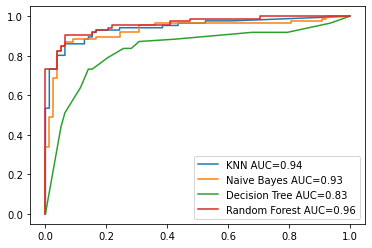

In [568]:
cross_validation_ROC_AUC(models,names,X_train,y_train)

KNN
              precision    recall  f1-score    support
0              0.869565  0.952381  0.909091  21.000000
1              0.900000  0.750000  0.818182  12.000000
accuracy       0.878788  0.878788  0.878788   0.878788
macro avg      0.884783  0.851190  0.863636  33.000000
weighted avg   0.880632  0.878788  0.876033  33.000000


Naive Bayes
              precision    recall  f1-score    support
0              0.913043  1.000000  0.954545  21.000000
1              1.000000  0.833333  0.909091  12.000000
accuracy       0.939394  0.939394  0.939394   0.939394
macro avg      0.956522  0.916667  0.931818  33.000000
weighted avg   0.944664  0.939394  0.938017  33.000000


Decision Tree
              precision    recall  f1-score   support
0              0.823529  0.666667  0.736842  21.00000
1              0.562500  0.750000  0.642857  12.00000
accuracy       0.696970  0.696970  0.696970   0.69697
macro avg      0.693015  0.708333  0.689850  33.00000
weighted avg   0.728610  0.696970  0

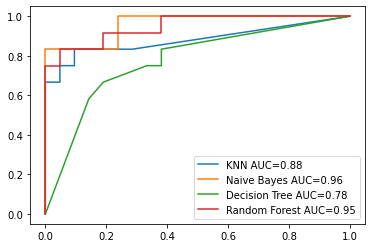

In [569]:
holdout_ROC_AUC(names,functions,X_train,y_train,[None,None,None,None])

KNN
              precision    recall  f1-score     support
0              0.729412  0.794872  0.760736   78.000000
1              0.797468  0.732558  0.763636   86.000000
accuracy       0.762195  0.762195  0.762195    0.762195
macro avg      0.763440  0.763715  0.762186  164.000000
weighted avg   0.765100  0.762195  0.762257  164.000000


Naive Bayes
              precision    recall  f1-score     support
0              0.709677  0.846154  0.771930   78.000000
1              0.830986  0.686047  0.751592   86.000000
accuracy       0.762195  0.762195  0.762195    0.762195
macro avg      0.770332  0.766100  0.761761  164.000000
weighted avg   0.773290  0.762195  0.761265  164.000000


Decision Tree
              precision    recall  f1-score     support
0              0.794521  0.743590  0.768212   78.000000
1              0.780220  0.825581  0.802260   86.000000
accuracy       0.786585  0.786585  0.786585    0.786585
macro avg      0.787370  0.784586  0.785236  164.000000
weighted avg  

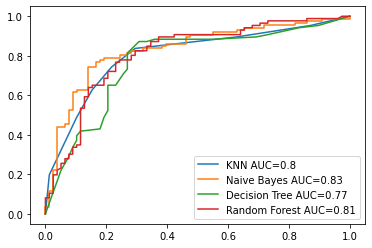

In [570]:
cross_validation_ROC_AUC(models_small,names,X_small_train,y_train)

KNN
              precision    recall  f1-score    support
0              0.800000  0.761905  0.780488  21.000000
1              0.615385  0.666667  0.640000  12.000000
accuracy       0.727273  0.727273  0.727273   0.727273
macro avg      0.707692  0.714286  0.710244  33.000000
weighted avg   0.732867  0.727273  0.729401  33.000000


Naive Bayes
              precision    recall  f1-score    support
0              0.772727  0.809524  0.790698  21.000000
1              0.636364  0.583333  0.608696  12.000000
accuracy       0.727273  0.727273  0.727273   0.727273
macro avg      0.704545  0.696429  0.699697  33.000000
weighted avg   0.723140  0.727273  0.724515  33.000000


Decision Tree
              precision    recall  f1-score    support
0              0.750000  0.714286  0.731707  21.000000
1              0.538462  0.583333  0.560000  12.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.644231  0.648810  0.645854  33.000000
weighted avg   0.673077  0.6666

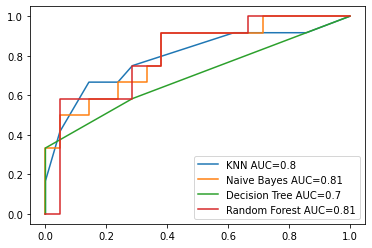

In [571]:
param_grids = [None,None,None,{"max_features":[1,2], "min_samples_split":[9,27,81,263],
                                                                     "n_estimators":[200]}]
holdout_ROC_AUC(names,functions,X_small_train,y_train, param_grids)